In [ ]:
import stereo as st
import scanpy as sc
import anndata as ad
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt
import Pathway_analysis
import os
import anndata as ad

In [6]:
import stereo as st
import scanpy as sc
import anndata as ad
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt

def meta_info(stereo_data, meta_data):
    stereo_data.cells["leiden"] = meta_data["leiden"]
    stereo_data.cells["batch"] = meta_data["sample_ID"]
    leiden = pd.DataFrame({"group":stereo_data.cells["leiden"]})
    leiden.index = stereo_data.cell_names
    stereo_data.tl.result["leiden"] = leiden  

def add_position(stereo_data):
    x = stereo_data.position[:,0].copy().tolist()
    y = stereo_data.position[:,1].copy().tolist()
    stereo_data.cells["x"] = x
    stereo_data.cells["y"] = y
    return stereo_data

def is_in_circle(x, y, center, radius):
    dx = x - center[0]
    dy = y - center[1]
    distances = np.sqrt(dx*dx + dy*dy)
    return distances <= radius

def draw_circle(stereo_data, center, radius):
    inside_circle = is_in_circle(
        stereo_data.cells["x"], 
        stereo_data.cells["y"], 
        center, 
        radius
    )
    loc_each_dot = pd.DataFrame({"x": stereo_data.cells["x"], "y":stereo_data.cells["y"]})
    return loc_each_dot[inside_circle] 

def count_circle_overlaps(dots, location, radius):
    x = dots["x"]
    y = dots["y"]
    count = []
    indx = []
    for i in range(len(location)):
        center = [location.iloc[i,1],location.iloc[i,2]]
        indx_tmp = str(location.iloc[i,1])+"x"+str(location.iloc[i,2])
        tmp = is_in_circle(x, y, center, radius)
        count.append(tmp)
        indx.append(indx_tmp)
    count_all = pd.DataFrame(count)
    count_all.index = indx
    return count_all

def check_circle(stereo_data, filtered_positions):
    loc_each_dot = pd.DataFrame({"x": stereo_data.cells["x"], "y":stereo_data.cells["y"]})
    plt.figure(figsize=(10, 10))
    plt.scatter(loc_each_dot["x"], loc_each_dot["y"], color='blue')
    plt.scatter(filtered_positions["x"], filtered_positions["y"], color='green')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Spatial distribution of barcodes')
    plt.gca().invert_yaxis()
    plt.show()
    
def inner_outer_points(data, sample, inner_circle, outer_circle, location):
    globals()[sample] = data.tl.filter_by_clusters(cluster_res_key = "sample", groups = sample)
    
    
    globals()["location_{}".format(sample)] = location[location["sample_ID"]==sample]
    # for the gene expression
    inner_points_list_all = []
    outter_points_spec_list_all = []
    for i in range(globals()["location_{}".format(sample)].shape[0]):
        coor = globals()["location_{}".format(sample)].iloc[i,[1,2]].tolist()
        inner_points = draw_circle(globals()[sample], [coor[0], coor[1]], radius = inner_circle)
        inner_points["Barcode"] = inner_points.index.tolist()

        # for the outer cells
        outter_points = draw_circle(globals()[sample], [coor[0], coor[1]], radius = outer_circle)
        #print(outter_points)
        outter_points["Barcode"] = outter_points.index.tolist()
        outter_points_spec = outter_points[~outter_points["Barcode"].isin(inner_points["Barcode"])]
        #print(outter_points_spec)
        count = count_circle_overlaps(outter_points_spec, globals()["location_{}".format(sample)], inner_circle)
        #print(count.sum())
        outter_points_spec_list = count.sum()[count.sum()==0].index.tolist()


        # save the inner points
        inner_points_list = inner_points["Barcode"].tolist()

        inner_points_list_all += inner_points_list
        outter_points_spec_list_all += outter_points_spec_list    
    
    # make the elements unique
    inner_points_list_all = list(set(inner_points_list_all))
    outter_points_spec_list_all = list(set(outter_points_spec_list_all))
        
    return inner_points_list_all, outter_points_spec_list_all

def concentric_preprocess(data, levels_list):
      
    inner_all = []
    outer_all = []
    for sample in globals()[levels_list]:
        inner, outer = inner_outer_points(
            data, 
            sample, 
            inner_circle=500, 
            outer_circle=1500, 
            location = location
        )
        inner_all += inner
        outer_all += outer

    all_list = inner_all + outer_all
    data_conc = data.tl.filter_cells(cell_list=all_list, inplace = False)
    return data_conc, inner_all
def concentric_with_subtype(data_conc, celltype, inner_all):    
    meta = data_conc.cells.to_df()
    inner_ref = pd.DataFrame({"barcode":inner_all, "concentric": "inner"})
    inner_ref.set_index('barcode', inplace=True)
    meta['concentric'] = meta['Unnamed: 0'].astype(str).map(inner_ref['concentric']).fillna('faraway')

    sub = meta[meta["annotation"]== celltype]

    data_sub = data.tl.filter_cells(cell_list=sub.index.tolist(), inplace = False)
    data_sub.cells["concentric"] = sub["concentric"].to_list()
    utils.cell_t0_res_key(data_sub)
    merge_raw.obs["barcode"] = merge_raw.obs.index.to_list()
    merge_subset =merge_raw[merge_raw.obs["barcode"].isin(data_sub.cells.to_df().index.to_list())]
    merge_subset.obs["concentric"] = data_sub.cells["concentric"].to_list()
    sc.tl.rank_genes_groups(merge_subset, 'concentric', method='t-test')
    return merge_subset

In [ ]:
# data list
control_list = ["B01806B5", "B01806B6", "B01809A3", "B01809A4", "D02175A4", "D02175A6"]
moderate_list = ["B02008D2", "B02009F6"]
advanced_list = ["B01809C2", "C02248B5"]
severe_list = ["A02092E1", "B02008C6"]
case_list = ["A02092E1", "B02008C6", "B02008D2", "B02009F6", "B01809C2", "C02248B5"]
all_list = ["B01806B5", "B01806B6", "B01809A3", "B01809A4", "D02175A4", "D02175A6",
           "A02092E1", "B02008C6", "B02008D2", "B02009F6", "B01809C2", "C02248B5"]

merge_raw = sc.read_h5ad("../Result/anndata/integrated_data/annotation_integrate.h5ad")

# load the location
location = pd.read_csv("../../50_bin_analysis/Result/Neuron_high_mt/high_mt_Ex_location.csv")
data = st.io.read_ann_h5ad(
                file_path="../Result/anndata/integrated_data/annotation_integrate.h5ad",
                spatial_key="spatial",
              )
meta_data = pd.read_csv("../Result/anndata/integrated_data/meta.csv")
for i in meta_data.columns:
    data.cells[i] = meta_data[i].to_list()

utils.cell_t0_res_key(data)

for i in ["control_list", "moderate_list", "advanced_list", "severe_list", "case_list", "all_list"]:
    control_conc, inner_all = concentric_preprocess(data, i)
    for cell in ['Opc', 'Undefined', 'End', 'Ex', 'Mic', 'Ast', 'Inh', 'Oli']:
        control_ex = concentric_with_subtype(control_conc, cell, inner_all)
        control_ex.write_h5ad("../Result/anndata/Concentric/{}/{}.h5ad".format(i, cell))

In [2]:
# read the data
merge_raw = sc.read_h5ad("../Result/anndata/integrated_data/annotation_integrate.h5ad")

# load the location
location = pd.read_csv("../../50_bin_analysis/Result/Neuron_high_mt/high_mt_Ex_location.csv")
data = st.io.read_ann_h5ad(
                file_path="../Result/anndata/integrated_data/annotation_integrate.h5ad",
                spatial_key="spatial",
              )
meta_data = pd.read_csv("../Result/anndata/integrated_data/meta.csv")
for i in meta_data.columns:
    data.cells[i] = meta_data[i].to_list()

utils.cell_t0_res_key(data)


In [39]:
data_sub = data.tl.filter_by_clusters(cluster_res_key = "sample", groups="B01809C2")

[2024-02-28 20:30:50][Stereo][144523][MainThread][47510116589248][st_pipeline][41][INFO]: start to run filter_by_clusters...
/work/ygong/conda-envs/st/lib/python3.8/site-packages/stereopy-1.0.0-py3.8.egg/stereo/preprocess/filter.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_res['group'] = cluster_res['group'].to_numpy()
/work/ygong/conda-envs/st/lib/python3.8/site-packages/stereopy-1.0.0-py3.8.egg/stereo/preprocess/filter.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_res['gro

In [40]:
location = pd.read_csv("../../50_bin_analysis/Result/Neuron_high_mt/high_mt_Ex_location.csv")

In [41]:
def inner_outer_points(data, sample, inner_circle, outer_circle, outer_circle2, location):
    globals()[sample] = data.tl.filter_by_clusters(cluster_res_key = "sample", groups = sample)
    
    
    globals()["location_{}".format(sample)] = location[location["sample_ID"]==sample]
    # for the gene expression
    inner_points_list_all = []
    outter_points_spec_list_all = []
    outter_points2_spec_list_all = []
    for i in range(globals()["location_{}".format(sample)].shape[0]):
        coor = globals()["location_{}".format(sample)].iloc[i,[1,2]].tolist()
        inner_points = draw_circle(globals()[sample], [coor[0], coor[1]], radius = inner_circle)
        inner_points["Barcode"] = inner_points.index.tolist()

        # for the outer cells
        outter_points = draw_circle(globals()[sample], [coor[0], coor[1]], radius = outer_circle)
        #print(outter_points)
        outter_points["Barcode"] = outter_points.index.tolist()
        outter_points_spec = outter_points[~outter_points["Barcode"].isin(inner_points["Barcode"])]
        #print(outter_points_spec)
        count = count_circle_overlaps(outter_points_spec, globals()["location_{}".format(sample)], inner_circle)
        #print(count.sum())
        outter_points_spec_list = count.sum()[count.sum()==0].index.tolist()

        # for the outer circle2 cells
        outter_points2 = draw_circle(globals()[sample], [coor[0], coor[1]], radius = outer_circle2)
        outter_points2["Barcode"] = outter_points2.index.tolist()
        # modified
        outter_points2_spec = outter_points2[~outter_points2["Barcode"].isin(outter_points["Barcode"])]
        count = count_circle_overlaps(outter_points2_spec, globals()["location_{}".format(sample)], outer_circle)
        outter_points2_spec_list = count.sum()[count.sum()==0].index.tolist()
    
        
        # save the inner points
        inner_points_list = inner_points["Barcode"].tolist()

        inner_points_list_all += inner_points_list
        outter_points_spec_list_all += outter_points_spec_list    
        outter_points2_spec_list_all += outter_points2_spec_list
    # make the elements unique
    inner_points_list_all = list(set(inner_points_list_all))
    outter_points_spec_list_all = list(set(outter_points_spec_list_all))
    outter_points2_spec_list_all = list(set(outter_points2_spec_list_all))
    return inner_points_list_all, outter_points_spec_list_all, outter_points2_spec_list_all 


In [42]:
inner, outer, outer2 = inner_outer_points(
    data = data, 
    sample = "B01809C2", 
    inner_circle=500, 
    outer_circle=1500, 
    outer_circle2=2500, 
    location = location
)

[2024-02-28 20:30:57][Stereo][144523][MainThread][47510116589248][st_pipeline][41][INFO]: start to run filter_by_clusters...
/work/ygong/conda-envs/st/lib/python3.8/site-packages/stereopy-1.0.0-py3.8.egg/stereo/preprocess/filter.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_res['group'] = cluster_res['group'].to_numpy()
/work/ygong/conda-envs/st/lib/python3.8/site-packages/stereopy-1.0.0-py3.8.egg/stereo/preprocess/filter.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_res['gro

In [83]:
def check_circle(stereo_data, filtered_positions):
    loc_each_dot = pd.DataFrame({"x": stereo_data.cells["x"], "y":stereo_data.cells["y"]})
    plt.figure(figsize=(10, 10))
    plt.scatter(loc_each_dot["x"], loc_each_dot["y"], color='grey')
    plt.scatter(filtered_positions["x"], filtered_positions["y"], color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Spatial distribution of barcodes')
    plt.gca().invert_yaxis()
    plt.axis('off')
    #plt.show()

In [92]:
data_sub_fil = data_sub.tl.filter_cells(cell_list = inner, inplace=False)

[2024-02-28 21:11:56][Stereo][144523][MainThread][47510116589248][st_pipeline][41][INFO]: start to run filter_cells...
[2024-02-28 21:11:57][Stereo][144523][MainThread][47510116589248][st_pipeline][44][INFO]: filter_cells end, consume time 0.6792s.


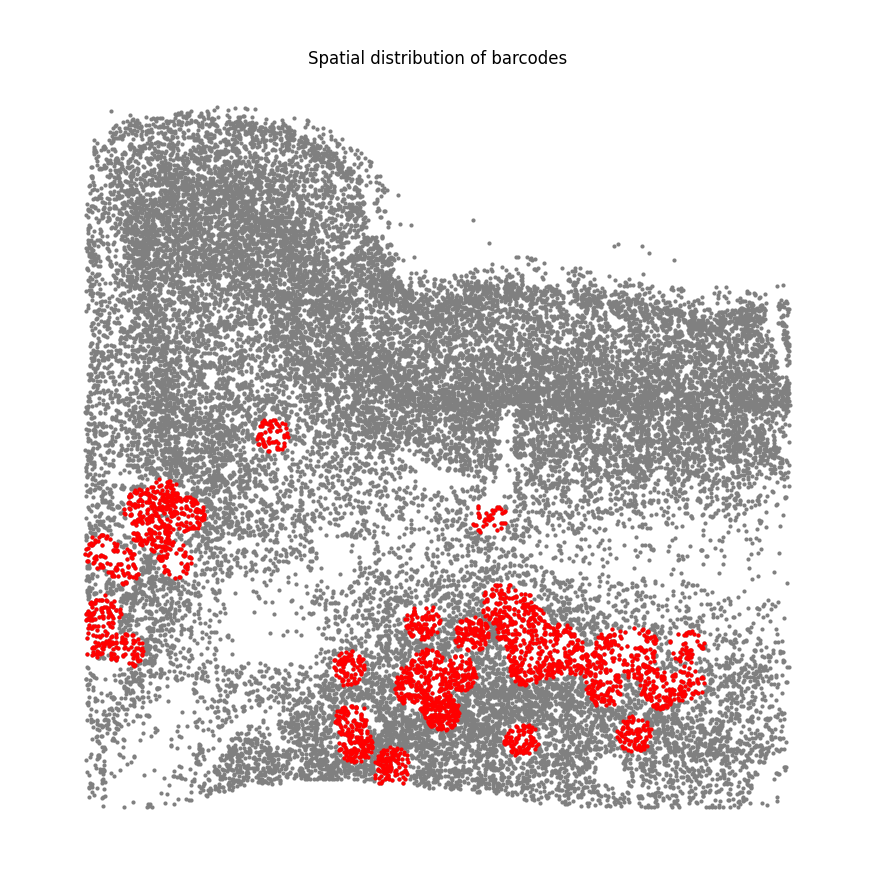

In [93]:
check_circle(data_sub, filtered_positions=data_sub_fil.cells.to_df())
plt.savefig("../Result/Figure/B01809C2_inner.png", dpi=300)

In [2]:
# read the reference for the neuron with tau aggregation
ref = pd.read_excel("../Result/Tau_gene.xlsx")

In [38]:
ref["Marker"].tolist()

['HSP90AA1',
 'NNAT',
 'MAP1A',
 'ATP1B1',
 'CPE',
 'PSAP',
 'STMN2',
 'SYT4',
 'ACTG1',
 'ATF4',
 'BASP1',
 'ENC1',
 'FTH1',
 'GPM6A',
 'GRIN2B',
 'MT-ND1',
 'NCAM1',
 'NSG2',
 'SARAF',
 'TUBB2A',
 'ACTB',
 'ANKRD12',
 'ARHGAP35',
 'CALM1',
 'CDK5R1',
 'CNTN1',
 'FAM171B',
 'FTL',
 'MAP2',
 'MARCKS',
 'PGM2L1',
 'PLPPR4',
 'RTN4',
 'SV2B',
 'UBC',
 'ATP1A3',
 'ATP2A2',
 'ATP6AP2',
 'AZIN1',
 'BNIP3',
 'CAMK2N1',
 'CANX',
 'CHL1',
 'CHN1',
 'CLSTN1',
 'DNAJA1',
 'EIF1',
 'KBTBD11',
 'KCNJ4',
 'LAMP1',
 'LMO4',
 'MLLT11',
 'NEFL',
 'NEFM',
 'OLFM1',
 'PNMA8A',
 'PTMA',
 'RELL2',
 'RTN1',
 'STMN1',
 'SUMO3',
 'TSC22D1',
 'TTC3',
 'UBE2B',
 'UBTF',
 'ZFAND5',
 'ADGRL3',
 'AHDC1',
 'APP',
 'BSN',
 'CBX6',
 'CD47',
 'CEBPB',
 'CNIH2',
 'CXXC5',
 'DNAJB6',
 'EIF4G2',
 'FAM49A',
 'FEM1B',
 'GABBR2',
 'GDA',
 'H3F3B',
 'HACD2',
 'HS6ST3',
 'HSPA13',
 'JUN',
 'MAFG',
 'MMD',
 'MT-ND4',
 'NORAD',
 'NRXN3',
 'NTM',
 'NTRK2',
 'PALM',
 'PPP1R9B',
 'PPP2CA',
 'PPP2CB',
 'PRICKLE2',
 'PTPRF',
 'REEP

In [6]:
Ex_severe = sc.read_h5ad("../Result/anndata/Concentric/severe_list/Ex_500_1500_2500.h5ad")
sc.tl.rank_genes_groups(Ex_severe, 'concentric', method='t-test', groups = ["inner"], referece = "outer2")
table = utils.DE_table(Ex_severe, gene_numbers = 20000000000)
table[table["Gene_name"] == "GFAP"]

,index,Group_key,Gene_name,Value,P_adjusted
52110,52110,inner,GFAP,-1.061956,9.429020e-23


In [7]:
overlap = table[table["Gene_name"].isin(ref["Marker"].tolist())]

In [8]:
len(overlap[(overlap["Value"]>0)&(overlap["P_adjusted"]<0.05)])

32

In [19]:
data = table.iloc[1:100,]

In [27]:
data[data["Gene_name"] == "CNTN1"]

,index,Group_key,Gene_name,Value,P_adjusted


In [4]:
Ex_severe = sc.read_h5ad("../Result/anndata/Concentric/severe_list/Ex_500_1500_2500.h5ad")
sc.tl.rank_genes_groups(Ex_severe, 'concentric', method='t-test', groups = ["inner"], referece = "outer2")
table = utils.DE_table(Ex_severe, gene_numbers = 20000000000000)
table[table["Gene_name"] == "MAP1A"]

,index,Group_key,Gene_name,Value,P_adjusted
12395,12395,inner,MAP1A,0.130906,1.0


In [117]:
Mic_severe = sc.read_h5ad("../Result/anndata/Concentric/severe_list/Mic_500_1500_2500.h5ad")
sc.tl.rank_genes_groups(Mic_severe, 'concentric', method='t-test', groups = ["inner"], referece = "outer2")
table = utils.DE_table(Mic_severe, gene_numbers = 20000000000000)
table[table["Gene_name"] == "GFAP"]

,index,Group_key,Gene_name,Value,P_adjusted
52117,52117,inner,GFAP,-1.766496,1.0


In [120]:
Oli_severe = sc.read_h5ad("../Result/anndata/Concentric/severe_list/Oli_500_1500_2500.h5ad")
sc.tl.rank_genes_groups(Oli_severe, 'concentric', method='t-test', groups = ["inner"], referece = "outer2")
table = utils.DE_table(Oli_severe, gene_numbers = 20000000000000)
table[table["Gene_name"] == "GFAP"]

,index,Group_key,Gene_name,Value,P_adjusted
52113,52113,inner,GFAP,-1.230926,0.000101


In [ ]:
# Inh low power due to the low cell numbers

In [128]:
End_severe = sc.read_h5ad("../Result/anndata/Concentric/severe_list/End_500_1500_2500.h5ad")
sc.tl.rank_genes_groups(End_severe, 'concentric', method='t-test', groups = ["inner"], referece = "outer2")
table = utils.DE_table(End_severe, gene_numbers = 20000000000000)
table[table["Gene_name"] == "GFAP"]

,index,Group_key,Gene_name,Value,P_adjusted
52114,52114,inner,GFAP,-0.917742,0.198285


In [10]:
# Opc severe
Opc_severe = sc.read_h5ad("../Result/anndata/Concentric/severe_list/Opc_500_1500_2500.h5ad")
sc.tl.rank_genes_groups(Opc_severe, 'concentric', method='t-test', groups = ["inner"], referece = "outer2")
table = utils.DE_table(Opc_severe, gene_numbers = 20000000000000)
table[table["Gene_name"] == "GFAP"]

,index,Group_key,Gene_name,Value,P_adjusted
52037,52037,inner,GFAP,-0.733618,1.0


In [30]:
# Opc severe
Inh_severe = sc.read_h5ad("../Result/anndata/Concentric/severe_list/Inh_500_1500_2500.h5ad")
sc.tl.rank_genes_groups(Inh_severe, 'concentric', method='t-test', groups = ["inner"], referece = "outer2")
table = utils.DE_table(Inh_severe, gene_numbers = 20000000000000)
table[table["Gene_name"] == "ATF4"]

,index,Group_key,Gene_name,Value,P_adjusted
1763,1763,inner,ATF4,26.218023,1.0


In [2]:
# read the cells in the severe levels
anndata = sc.read_h5ad("../Result/anndata/Concentric/severe_list/Mic_500_1500_2500.h5ad")

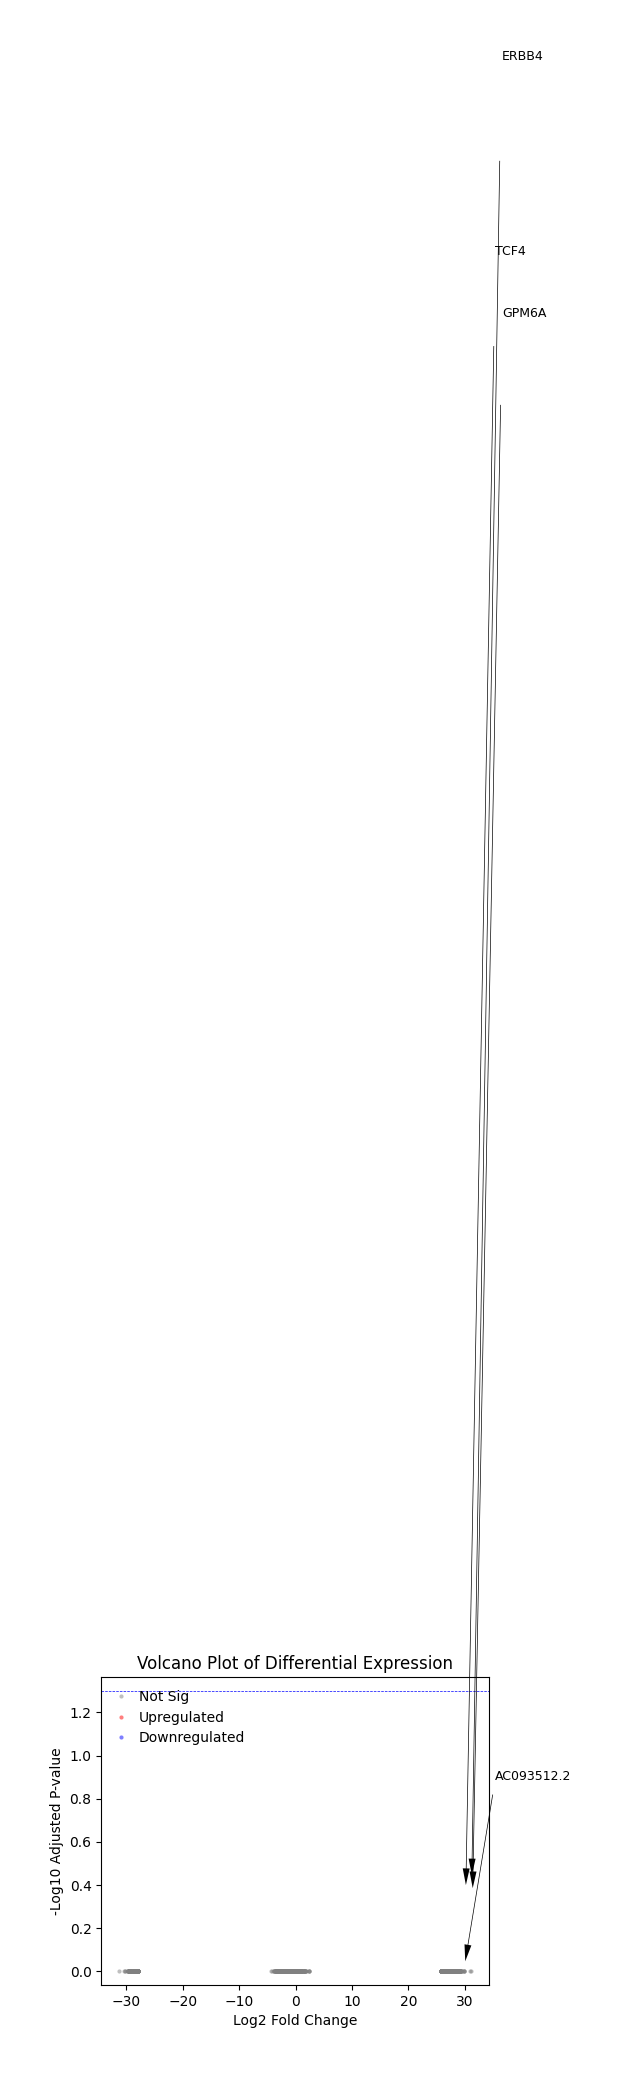

In [14]:
df = table

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and is already loaded with your data

# Calculate -log10 of the P_adjusted
df['negLog10PAdj'] = -np.log10(df['P_adjusted'])

# Define the figure and axis
fig, ax = plt.subplots(figsize=(5, 4))

# Define significance threshold for adjusted p-value
significance_threshold = 0.05  # e.g., 0.05 for a p-value of 5%

# Identifying upregulated, downregulated, and non-significant genes
upregulated = (df['Value'] > 0) & (df['P_adjusted'] < significance_threshold)
downregulated = (df['Value'] < 0) & (df['P_adjusted'] < significance_threshold)
nonsignificant = df['P_adjusted'] >= significance_threshold

# Plot non-significant genes in gray
ax.scatter(df.loc[nonsignificant, 'Value'], df.loc[nonsignificant, 'negLog10PAdj'], color='gray', label='Not Sig', alpha=0.5)

# Plot upregulated genes in red
ax.scatter(df.loc[upregulated, 'Value'], df.loc[upregulated, 'negLog10PAdj'], color='red', label='Upregulated', alpha=0.5)

# Plot downregulated genes in blue
ax.scatter(df.loc[downregulated, 'Value'], df.loc[downregulated, 'negLog10PAdj'], color='blue', label='Downregulated', alpha=0.5)

# Title and labels
ax.set_title('Volcano Plot of Differential Expression')
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('-Log10 Adjusted P-value')

# Annotate the first 10 genes with more distance and a line pointing to the spot
for i, row in df.head(4).iterrows():
    ax.annotate(row['Gene_name'], 
                 xy=(row['Value'], row['negLog10PAdj']),
                 xytext=(row['Value'] + 5.5, row['negLog10PAdj'] + (np.random.rand() - 1) * 10 + 10),  # Adjust text position
                 arrowprops=dict(facecolor='black', width=0.5, headwidth=5, shrink=0.05),
                 fontsize=9)

# Horizontal line for significance threshold
plt.axhline(-np.log10(significance_threshold), color='blue', linestyle='--')

# Legend
plt.legend()

# Show the plot
plt.show()


In [12]:
table

,index,Group_key,Gene_name,Value,P_adjusted,negLog10PAdj
0,0,inner,FRMD5,28.586409,0.036458,1.438202
1,1,inner,CRYAB,28.167101,0.215068,0.667423
2,2,inner,ANKH,28.260193,0.215068,0.667423
3,3,inner,ATP6V0A1,28.099779,0.304060,0.517040
4,4,inner,KHDRBS3,28.190325,0.304060,0.517040
...,...,...,...,...,...,...
52119,52119,inner,MT-TV,-1.609521,0.215068,0.667423
52120,52120,inner,MT-ATP6,-1.595306,0.000330,3.481135
52121,52121,inner,MT-ND4,-1.580337,0.000203,3.693312
52122,52122,inner,MT-CO3,-2.077978,0.000097,4.012391


In [8]:
# read the data
data_list = []
for level in ["control", "moderate", "advanced", "severe"]:
    for file in os.listdir("../Result/anndata/Concentric/{}_list/".format(level)):
        if "_1500_2500.h5ad" in file:
            tmp = sc.read("../Result/anndata/Concentric/{}_list/{}".format(level, file))
            data_list.append(tmp)

KeyboardInterrupt: 

In [17]:
merge = ad.concat(data_list, join="outer")

In [30]:
# read the raw h5ad data
merge.raw.X

<86626x52124 sparse matrix of type '<class 'numpy.float32'>'
	with 28274536 stored elements in Compressed Sparse Row format>

In [31]:
from scipy.io import mmwrite
from scipy import sparse
import numpy as np

mmwrite('../Result/Concentric_to_R/concentric_matrix.mtx', merge.raw.X)

In [38]:
# write the obs
meta = merge.obs.copy()
meta.to_csv("../Result/Concentric_to_R/meta_data.csv")

merge.var.to_csv("../Result/Concentric_to_R/feature.csv")

merge.raw.var.to_csv("../Result/Concentric_to_R/raw_feature.csv")

In [45]:
# set all the data
merge = sc.read_h5ad("../Result/anndata/integrated_data/annotation_integrate.h5ad")

tmp_merge = []
for data in os.listdir("../Result/anndata/Concentric/all_list/"):
    if "_500_1500_2500" in data:
        tmp = sc.read_h5ad("../Result/anndata/Concentric/all_list/" + data)
        tmp_merge.append(tmp)
concentric = ad.concat(tmp_merge, join = "outer")

concentric_meta = pd.DataFrame({"barcode":concentric.obs.index.to_list(), "concentric": concentric.obs["concentric"]})

merge_meta = merge.obs.copy()
merge_meta["barcode"] = merge_meta.index.to_list()

merged_df = pd.merge(merge_meta, concentric_meta, on='barcode', how='outer')


if 'outer3' not in merged_df['concentric'].cat.categories:
    merged_df['concentric'] = merged_df['concentric'].cat.add_categories(['outer3'])
merged_df['concentric'].fillna('outer3', inplace=True)

merge.obs["concentric"].value_counts()

In [46]:
# write to the R format
from scipy.io import mmwrite
from scipy import sparse
import numpy as np

mmwrite('../Result/Concentric_to_R/concentric_outer3_all.mtx', merge.raw.X)

In [47]:
# write the obs
meta = merge.obs.copy()
meta.to_csv("../Result/Concentric_to_R/outer3_meta_data.csv")

merge.var.to_csv("../Result/Concentric_to_R/outer3_feature.csv")

merge.raw.var.to_csv("../Result/Concentric_to_R/outer3_raw_feature.csv")

In [2]:
# read the raw data
control_list = ["B01806B5", "B01806B6", "B01809A3", "B01809A4", "D02175A4", "D02175A6"]
moderate_list = ["B02008D2", "B02009F6"]
advanced_list = ["B01809C2", "C02248B5"]
severe_list = ["A02092E1", "B02008C6"]
###### Control
# import the stereo data
for num,files in enumerate(control_list):
    data_path = "../Result/anndata/raw_data/{}.h5ad".format(files)
    data = sc.read_h5ad(data_path)
    data.obs["diagnosis"] = "control"
    data.obs["sample"] = files
    data.obs["levels"] = "control"
    globals()[files] = data
    print(files)

###### moderate_list
# import the stereo data
for num,files in enumerate(moderate_list):
    data_path = "../Result/anndata/raw_data/{}.h5ad".format(files)
    data = sc.read_h5ad(data_path)
    data.obs["diagnosis"] = "case"
    data.obs["sample"] = files
    data.obs["levels"] = "moderate"
    globals()[files] = data
    print(files)

##### advanced_list
# import the stereo data
for num,files in enumerate(advanced_list):
    data_path = "../Result/anndata/raw_data/{}.h5ad".format(files)
    data = sc.read_h5ad(data_path)
    data.obs["diagnosis"] = "case"
    data.obs["sample"] = files
    data.obs["levels"] = "advanced"
    globals()[files] = data
    print(files)

##### severe_list
# import the stereo data
for num,files in enumerate(severe_list):
    data_path = "../Result/anndata/raw_data/{}.h5ad".format(files)
    data = sc.read_h5ad(data_path)
    data.obs["diagnosis"] = "case"
    data.obs["sample"] = files
    data.obs["levels"] = "severe"
    globals()[files] = data
    print(files)

merge = ad.concat(
    [B01806B5, B01806B6, B01809A3, B01809A4, 
     D02175A4, D02175A6,A02092E1, B02009F6, 
     C02248B5, B02008C6, B02008D2, B01809C2],
    join = "outer"
)

B01806B5
B01806B6
B01809A3
B01809A4
D02175A4
D02175A6
B02008D2
B02009F6
B01809C2
C02248B5
A02092E1
B02008C6


/work/ygong/conda-envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/work/ygong/conda-envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
merge.obs_names_make_unique()
merge = merge[merge.obs["n_genes_by_counts"]>=150]
merge.raw = merge

In [12]:
# write the raw data
from scipy.io import mmwrite
from scipy import sparse
import numpy as np

matrix = merge.X
matrix = matrix.astype(np.float32)
mmwrite('../Result/Concentric_to_R/concentric_outer3_all_rawdata.mtx', matrix)